In [1]:
import json
import glob
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [2]:
os.chdir('/home/walml/repos/morphology-tools/anomaly')
import shared

In [3]:

# and read it back...

dataset_name = 'gz2'
method = 'cnn'
experiment_name = '40comp'

# # df_loc = 'anomaly/results/{}/gp_metrics_{}_{}.csv'.format(dataset_name, method, experiment_name)
# df_loc = '/home/walml/repos/morphology-tools/anomaly/results/gz2/gp_metrics_cnn_cnn_odd_final_0.csv'
# df = pd.read_csv(df_loc)




In [4]:
# df.head()

In [5]:
gp_records = [json.load(open(loc, 'r')) for loc in glob.glob('/home/walml/repos/morphology-tools/anomaly/results/gz2/predictions_gp_cnn_cnn_odd_kagglev3_*.json')]

In [6]:
forest_records = [json.load(open(loc, 'r')) for loc in glob.glob('/home/walml/repos/morphology-tools/anomaly/results/gz2/predictions_forest_ellipse_kaggle_ellipse_odd_*.json')]

In [7]:

for record in gp_records:
    for key, value in record.items():
        record[key] = np.array(value)

for record in forest_records:
    for key, value in record.items():
        record[key] = np.array(value)




In [8]:
gp_records[0].keys()

dict_keys(['preds_gp_only', 'preds_with_labels', 'responses', 'labels', 'acquired_features', 'acquired_labels'])

In [9]:
forest_records[0].keys()

dict_keys(['preds_with_labels', 'responses', 'labels', 'acquired_features', 'acquired_labels'])

recall = tp / tp+fn

precision = tp/tp+fp

hard to interpret as we're saying all the top k are predicted true/anomaly
so fn=0 -> recall=1
and fp=N-tp -> precision = tp/N, but accuracy =tp+tn/N and tn=0 -> accuracy=tp/N = precision

In [10]:
# plt.hist(gp_records[0]['preds_gp_only'], bins=30)
# plt.axvline(4.5, color='r')

In [11]:
# (gp_records[0]['preds_gp_only'] > 4.5).mean(), gp_records[0]['labels'].mean()  # gp predictions are useful for ordering but are not well-calibrated (reasonable given the skewed labels)

In [12]:
# http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html
    
def get_top_n_precision(y, y_est):
#   relevant recommended items / all recommended items
    assert len(y) == len(y_est)
    precisions = np.zeros(len(y)) * np.nan
    
    y_sorted = y[np.argsort(y_est)[::-1]]
    for n in range(1, len(y)):
        precisions[n] = y_sorted[:n].mean()  # i.e the sum of relevant items recommended / N, it's the same as accuracy
    return precisions


def get_top_n_recall(y, y_est):
    # relevant recommended items / relevant items which might have been recommended
    assert len(y) == len(y_est)
    recalls = np.zeros(len(y)) * np.nan
    
    y_sorted = y[np.argsort(y_est)[::-1]]
    for n in range(1, len(y)):
        max_relevant_items = min(y.sum(), n)  # relevent items is either every relevant item or all N being relevant, whichever is lower. When y.sum > n, identical to precision
        recalls[n] = y_sorted[:n].sum() / max_relevant_items
    return recalls



In [13]:
gp_records[0]['labels'].sum(), forest_records[0]['labels'].sum() # should match if venn diagram done correctly

(835, 835)

In [14]:
assert gp_records[0]['labels'].sum() == forest_records[0]['labels'].sum()

In [15]:
gp_precisions = [get_top_n_precision(record['labels'], record['preds_with_labels']) for record in gp_records]
gp_recalls = [get_top_n_recall(record['labels'], record['preds_with_labels']) for record in gp_records]

In [16]:
forest_precisions = [get_top_n_precision(record['labels'], record['preds_with_labels']) for record in forest_records]
forest_recalls = [get_top_n_recall(record['labels'], record['preds_with_labels']) for record in forest_records]

In [20]:
max_to_consider = 1500


In [21]:

# plt.plot(np.arange(len(gp_recalls))[:max_to_consider], gp_recalls[:max_to_consider], label='GP Recall at N')
# plt.plot(np.arange(len(gp_precisions))[:max_to_consider], gp_precisions[:max_to_consider], label='GP Precision (Acc) at N')

# plt.plot(np.arange(len(forest_recalls))[:max_to_consider], forest_recalls[:max_to_consider], label='F Recall at N')
# plt.plot(np.arange(len(forest_precisions))[:max_to_consider], forest_precisions[:max_to_consider], label='F Precision (Acc) at N')

# plt.legend()
# plt.ylim([0., 1.])
# plt.xlim([0., max_to_consider])

In [22]:
forest_precisions[0].shape

(59727,)

(0.0, 500)

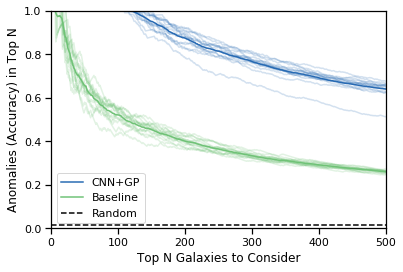

In [23]:
for (experiment, label, color) in [(gp_precisions, 'CNN+GP', 'xkcd:mid blue'), (forest_precisions, 'Baseline', 'xkcd:soft green')]:
        for run in experiment:
            plt.plot(np.arange(len(run))[:max_to_consider], run[:max_to_consider], color=color, alpha=.2)

        mean_scores = np.mean(np.array([run for run in experiment]), axis=0)
        plt.plot(np.arange(len(run))[:max_to_consider], mean_scores[:max_to_consider], color=color, label=label)

plt.axhline(gp_records[0]['labels'].mean(), linestyle='--', label='Random', color='k')
plt.xlabel('Top N Galaxies to Consider')
plt.ylabel('Anomalies (Accuracy) in Top N')
plt.legend()
plt.ylim([0., 1.])
plt.xlim([0., 500])

In [24]:
from sklearn.metrics import average_precision_score

In [25]:
gp_average_precisions = np.array([average_precision_score(y_true=record['labels'], y_score=record['preds_with_labels']) for record in gp_records])
gp_average_precisions.mean(), gp_average_precisions.std()

(0.5449726512714756, 0.03457931953541073)

In [26]:
forest_average_precisions = np.array([average_precision_score(y_true=record['labels'], y_score=record['preds_with_labels']) for record in forest_records])
forest_average_precisions.mean(), forest_average_precisions.std()

(0.15576466455326543, 0.005721349853828271)

In [27]:
gp_ranks = [np.argsort(record['preds_with_labels'])[::-1] for record in gp_records]
gp_sorted_labels = [record['labels'][rank].astype(bool) for record, rank in zip(gp_records, gp_ranks)]

gp_rws = np.zeros((len(gp_ranks), len(gp_ranks[0]))) * np.nan
for labels_n, labels in enumerate(gp_sorted_labels):
    for n in range(max_to_consider):
        gp_rws[labels_n, n] = shared.get_rank_weighted_score(labels, n=n)
        
forest_ranks = [np.argsort(record['preds_with_labels'])[::-1] for record in forest_records]
forest_sorted_labels = [record['labels'][rank].astype(bool) for record, rank in zip(forest_records, forest_ranks)]
forest_rws = np.zeros((len(forest_ranks), len(forest_ranks[0]))) * np.nan
for labels_n, labels in enumerate(forest_sorted_labels):
    for n in range(max_to_consider):
        forest_rws[labels_n, n] = shared.get_rank_weighted_score(labels, n=n)

# forest_rank = np.argsort(forest_records[0]['preds_with_labels'])[::-1]
# forest_sorted_labels = forest_records[0]['labels'][forest_rank].astype(bool)
# forest_rws = np.array([shared.get_rank_weighted_score(forest_sorted_labels, n=n) for n in range(max_to_consider)])

/home/walml/repos/morphology-tools/anomaly/shared.py:368: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(weights * is_interesting_top) / s_zero


In [28]:
gp_rws.shape, len(gp_sorted_labels)

((15, 59727), 15)

(0.0, 500)

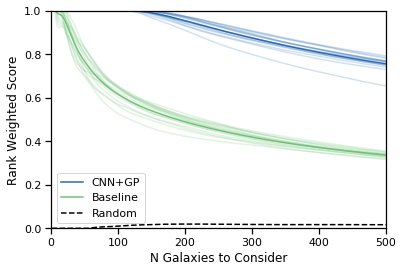

In [29]:
for (experiment, label, color) in [(gp_rws, 'CNN+GP', 'xkcd:mid blue'), (forest_rws, 'Baseline', 'xkcd:soft green')]:
        for run in experiment:
            plt.plot(np.arange(len(run))[:max_to_consider], run[:max_to_consider], color=color, alpha=.2)

        mean_scores = np.mean(np.array([run for run in experiment]), axis=0)
        plt.plot(np.arange(len(run))[:max_to_consider], mean_scores[:max_to_consider], color=color, label=label)

random_labels = gp_records[0]['labels'].copy()
random.shuffle(random_labels)
random_rws = [shared.get_rank_weighted_score(random_labels, n=n) for n in range(max_to_consider)]
# plt.axhline(gp_records[0]['labels'].mean(), linestyle='--', label='Random', color='k')
plt.plot(random_rws, color='k', linestyle='--', label='Random')

plt.ylim([0., 1.])
plt.legend()
plt.ylabel('Rank Weighted Score')
plt.xlabel('N Galaxies to Consider')
# plt.xlim([0., max_to_consider])
plt.xlim([0., 500])